In [0]:

from google.colab import drive
drive.mount('/content/drive')
!mkdir -p drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
%matplotlib inline
import random
import scipy.misc
import cv2

In [0]:
os.listdir(DATA_DIR+"/flickr")


['flickr30k_images', 'flickr30k-BW']

In [0]:
PATH=r'/content/drive/My Drive/Colab Notebooks/GAN'
SNAP_SHOT_DIR=r'/content/drive/My Drive/Colab Notebooks/GAN/Snapshots'
MODEL_DIR= r'/content/drive/My Drive/Colab Notebooks/GAN/Models'
LOGS_DIR=r'/content/drive/My Drive/Colab Notebooks/GAN/logs'
DATA_DIR = r'/content/drive/My Drive/Colab Notebooks/GAN/Data'


In [0]:
os.listdir(r'/content/drive/My Drive/Colab Notebooks/GAN')

['Notebooks', 'Models', 'Snapshots', 'Data', 'logs']

In [0]:
def show_generator_output(x,name,is_save= False):
  

  x= np.reshape(x,(x.shape[1],x.shape[1],x.shape[3]))
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
  if is_save:
     
    scipy.misc.imsave(os.path.join(SNAP_SHOT_DIR, "{}.jpg".format(name)), x)
  
  x=np.array((x - np.min(x)) / (np.max(x) - np.min(x)))
  plt.imshow(x)
  plt.pause(0.05)
  
  
  
  
def initialize_unit_vars(sess):
    t_vars= tf.global_variables()
    unint_vars_names = sess.run(tf.report_uninitialized_variables(t_vars))
    unint_vars_names = [u.decode("utf-8") for u in unint_vars_names]
    unint_vars = [ v for v in tf.global_variables() if v.name.split(':')[0] in unint_vars_names]
    sess.run(tf.variables_initializer(unint_vars))
  
  
  
def random_batch_generator(batch_size,res):
  

    idx = np.arange(1 , 1819)
    np.random.shuffle(idx)
    idx=idx[:batch_size]
    resized_img=[]
    img_path = os.path.join(DATA_DIR,res)
    for name in idx:

        filename ="{}.jpg".format(name)
        img_path2=os.path.join(img_path,filename)
        img=cv2.imread(img_path2)


        resized_img.append(img)
    
    resized_img= np.array(resized_img)

    resized_img=resized_img.reshape(resized_img.shape[0], resized_img.shape[1], resized_img.shape[2], 3)
    return resized_img




def PixelNorm(x, epsilon = 1e-8):
  return x * tf.rsqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + epsilon)

def new_sheet(filters, kernel_size, padding, name, pix_norm = True,stride =1):
  def func(layer):
    layer = tf.layers.conv2d(layer, filters, kernel_size, strides = stride, padding=padding, name = name, kernel_initializer = initialization)       
    layer = tf.nn.leaky_relu(layer, alpha=0.2) 
    if pix_norm: layer = PixelNorm(layer)
    return layer
  return func



def upscale2d(x, factor=2):
    assert isinstance(factor, int) and factor >= 1
    if factor == 1: return x
    with tf.variable_scope('Upscale2D'):

        s = x.shape
        x = tf.reshape(x, [-1, s[1], 1, s[2], 1, s[3]])
        x = tf.tile(x, [1, 1, factor, 1, factor, 1])
        x = tf.reshape(x, [-1, s[1] * factor, s[2] * factor, s[3]])
        return x
      
      
      
def transition_alpha(lr,epoch,epochs):
    epoch = epoch
    epochs =epochs
    a = epoch / (epochs/ 2)
    b = 1
    c=min(a, b) 
    return lr*c
  
  
  
def MiniBatchStddev(x, group_size=4):
  group_size = tf.minimum(group_size, tf.shape(x)[0])
  s = x.shape                                             
  y = tf.reshape(x, [group_size, -1, s[1], s[2], s[3]])   
  y = tf.cast(y, tf.float32)                              
  y -= tf.reduce_mean(y, axis=0, keepdims=True)           
  y = tf.reduce_mean(tf.square(y), axis=0)                
  y = tf.sqrt(y + 1e-8)                                   
  y = tf.reduce_mean(y, axis=[1,2,3], keepdims=True)      
  y = tf.cast(y, x.dtype)                                 
  y = tf.tile(y, [group_size, s[1], s[2], 1])             
  return tf.concat([x, y], axis=-1)    




def hw_flatten(x) :
  
  s= x.shape
  return tf.reshape(x, [-1, s[1]*s[2], s[3]])






def attention(layer, ch, name, reuse=False):

  with tf.variable_scope('attention'  , reuse=reuse):

    f = new_sheet(ch//3, (1,1), 'same', 'f_conv'+"{}".format(name))(layer)
    g = new_sheet(ch//3, (1,1), 'same', 'g_conv'+"{}".format(name))(layer)
    h=  new_sheet(ch, (1,1), 'same', 'h_conv')(layer)


    # N = h * w
    s = tf.matmul(hw_flatten(g), hw_flatten(f), transpose_b=True) # # [bs, N, N]

    beta = tf.nn.softmax(s)  # attention map

    o = tf.matmul(beta, hw_flatten(h)) # [bs, N, C]
    gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

    ss=layer.shape
    o = tf.reshape(o, shape=(-1,ss[1],ss[2],ss[3])) # [bs, h, w, C]
    layer = gamma * o + layer

    return layer

In [0]:
class GAN(object):


  def __init__(self,sess,input_dim,z_dim,
               res,sheets,resolution_list):

    self.sess = sess
    self.input_dim = input_dim
    self.z_dim = z_dim
    self.epoch = tf.Variable(0)
    self.epochs = tf.Variable(0)
    self.res = res
    self.sheets= sheets

  def model_inputs(self,real_dim, z_dim):

    input_real = tf.placeholder(tf.float32,(None,*real_dim),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    lr_g = tf.placeholder(tf.float32,name='lr_g')
    lr_d = tf.placeholder(tf.float32,name='lr_d')

    return input_real,input_z,lr_g,lr_d
  
  
  
  def generator(self,z,is_reuse):
    with tf.variable_scope("generator",reuse =  is_reuse):
      previous_step = None
      next_step = None
      
      
      z = tf.layers.dense(z,4*4*512)
      layer = tf.reshape(z,(-1,4,4,512))
      layer= tf.nn.leaky_relu(layer,alpha=alpha)

      layer = new_sheet(filters_list[0], (4,4), 'same', 'genr_head_0')(layer)
      layer = new_sheet(filters_list[0], (3,3), 'same', 'genr_head_1')(layer)




      for i in range(self.sheets):

        layer = upscale2d(layer)
        
        if i == self.sheets-1:
          previous_step = layer
          

        
        
        layer = new_sheet(filters_list[i+1], (4,4), 'same', 'genr_layer_0'+"{}".format(i))(layer)
        layer = new_sheet(filters_list[i+1], (3,3), 'same', 'genr_layer_1'+"{}".format(i))(layer)

      next_step = tf.layers.conv2d(layer,channels,(1,1),name="to_rgb_"+"{}".format(sheets)
                                   ,kernel_initializer = initialization)
      
     
      if previous_step is not None:
        
        previous_step = tf.layers.conv2d(layer,channels,(1,1),name="to_rgb2_"+"{}".format(sheets-1)
                                   ,kernel_initializer = initialization)
        

        layer = previous_step +(next_step -previous_step)
      
      

    
      
        if self.res==16 or 32 or 64:  
          layer = attention(layer, channels , "{}".format(self.res), reuse=is_reuse)
      
      else:
        
        layer = next_step 
        
        
      return layer 

    
    
    
    

  def discriminator(self,x, is_reuse):

    with tf.variable_scope("discriminator", reuse =  is_reuse):
      previous_step = None
      next_step = None
      
      
      input_layer = x
      

      layer = tf.layers.conv2d(input_layer, filters_list[sheets],
                               (1,1),  name = 'from_rgb_'+str(sheets), 
                               kernel_initializer = initialization) 
      layer = tf.nn.leaky_relu(layer, alpha=0.2)

      
      for i in range(self.sheets, 0, -1):
        
        
        layer = new_sheet(filters_list[i], (3,3), 'same', 'disc_layer_b'+str(i), pix_norm = False)(layer)
        layer = new_sheet(filters_list[i - 1], (3,3), 'same', 'disc_layer_a'+str(i), pix_norm = False)(layer)
        layer = tf.layers.average_pooling2d(layer, 2, 2)
        
        
        
        
        if i == sheets:
          
          next_step = layer

          previous_step = tf.layers.average_pooling2d(input_layer, 2, 2)
          previous_step = tf.layers.conv2d(previous_step, filters_list[i - 1], 
                                           (1,1), name = 'from_rgb_'+str(sheets - 1), kernel_initializer = initialization) #from RGB
          previous_step = tf.nn.leaky_relu(previous_step, alpha=0.2)       
          
          
          
          layer = previous_step + (next_step - previous_step)
        
        
        
        
      layer =  MiniBatchStddev(layer, group_size=4)
      layer = new_sheet(filters_list[0], (3,3), 'same', 'disc_head_0', pix_norm = False)(layer)
      layer = new_sheet(filters_list[0], (4,4), 'valid', 'disc_head_1', pix_norm = False)(layer)
      

      if self.res==16 or 32 or 64:  
        
        layer = attention(layer, filters_list[0] ,"{}".format(self.res), reuse=is_reuse)

      layer = tf.layers.flatten(layer)
      logits = tf.layers.dense(layer, 1, kernel_initializer = initialization)
      out= tf.sigmoid(logits)

      return out,logits

      
      


  def model_loss(self,input_real,input_z):
      g_model= self.generator(input_z,is_reuse)

      d_model_real,d_logits_real = self.discriminator(input_real,is_reuse)
      d_model_fake,d_logits_fake = self.discriminator(g_model,is_reuse= True)
      d_loss_real =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real, labels = tf.ones_like(d_model_real)))
      d_loss_fake =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels = tf.zeros_like(d_model_fake)))
      g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_model_fake ,labels = tf.ones_like(d_model_fake)))
      d_loss = d_loss_real + d_loss_fake
      return d_loss , g_loss


  def model_optimizers(self,d_loss,g_loss ,lr_g,lr_d,beta1):
        t_vars = tf.trainable_variables()
        g_vars = [var for var in t_vars if var.name.startswith("generator")]
        d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        gen_updates = [op for op in update_ops if op.name.startswith("generator")]
        with tf.control_dependencies(gen_updates):
            with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
                d_train_opt = tf.train.AdamOptimizer(learning_rate =lr_d,beta1= beta1).minimize(d_loss, var_list= d_vars)
            with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
                g_train_opt = tf.train.AdamOptimizer(learning_rate =lr_g, beta1=beta1).minimize(g_loss, var_list= g_vars)
        return d_train_opt, g_train_opt  
  
            
            
            
            
            
  def train_on_batch(self,batch_size,path,epochs,beta1,alpha,
        learning_rate_G,learning_rate_D):
    
      input_images, input_z,lr_G, lr_D =self.model_inputs(self.input_dim, self.z_dim)
      d_loss, g_loss= self.model_loss(input_images, input_z)
      d_opt, g_opt = self.model_optimizers(d_loss, g_loss, lr_G, lr_D, beta1)
      
      saver = tf.train.Saver()
      if from_checkpoint:
          print("restoring model")
          saver.restore(sess,os.path.join(MODEL_DIR,"model.ckpt"))
      initialize_unit_vars(sess)
      writer = tf.summary.FileWriter(LOGS_DIR,sess.graph)
      self.epoch.load(0,self.sess)
      self.epochs.load(epochs,self.sess)
      i =0
      for epoch in range(epochs):
          self.epoch.load(epoch,self.sess)
          print("Loading images")
          batch_images= random_batch_generator(batch_size,path)
          batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

          learning_rate_D2= transition_alpha(learning_rate_D,epoch,epochs)
          learning_rate_G2= transition_alpha(learning_rate_G,epoch,epochs)
      
          _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D2})
          _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G2})

          i+=1
          if i % 50 == 0:
              train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
              train_loss_g = g_loss.eval({input_z: batch_z})
              example_z = np.random.uniform(-1, 1, size=[1, self.z_dim])
              samples = sess.run(self.generator(input_z,True),feed_dict={input_z: example_z})
              is_save= False
              
              
          if i % 100 == 0:
              is_save= True
              show_generator_output(samples,str(self.epoch),is_save)
              print("Epoch {}/{}...".format(epoch, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

          if  i % 200 ==0:
              print("saving Model")
              
              new_model_path = os.path.join(MODEL_DIR,path)
              print(new_model_path)
              save_path = saver.save(sess,os.path.join(new_model_path,'model.ckpt'))  
  

Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading im

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


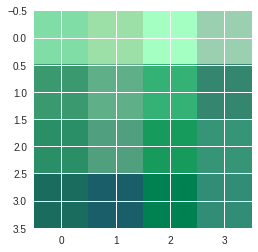

Epoch 99/1000... Discriminator Loss: 1.5179... Generator Loss: 0.4114
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


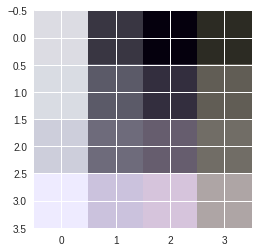

Epoch 199/1000... Discriminator Loss: 1.4846... Generator Loss: 0.4586
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Four
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loadi

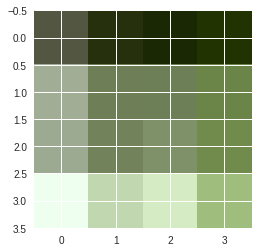

Epoch 299/1000... Discriminator Loss: 1.5695... Generator Loss: 0.4427
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

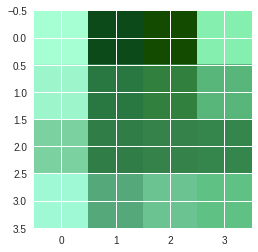

Epoch 399/1000... Discriminator Loss: 1.1413... Generator Loss: 0.4841
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Four
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loadi

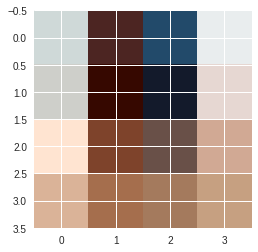

Epoch 499/1000... Discriminator Loss: 1.3795... Generator Loss: 0.4657
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

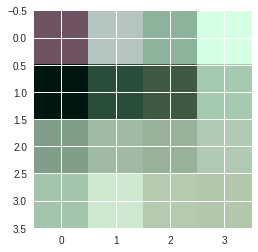

Epoch 599/1000... Discriminator Loss: 1.4212... Generator Loss: 0.4479
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Four
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loadi

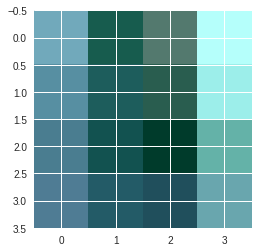

Epoch 699/1000... Discriminator Loss: 1.1822... Generator Loss: 0.4909
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

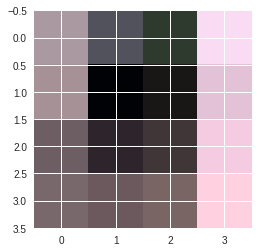

Epoch 799/1000... Discriminator Loss: 1.5138... Generator Loss: 0.4439
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Four
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loadi

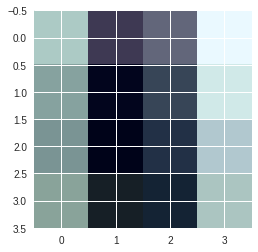

Epoch 899/1000... Discriminator Loss: 1.5021... Generator Loss: 0.4529
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

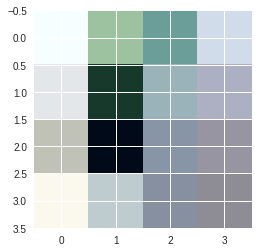

Epoch 999/1000... Discriminator Loss: 1.4676... Generator Loss: 0.4440
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Four
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading

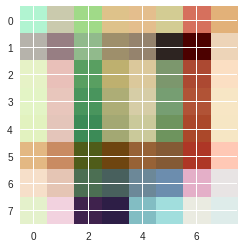

Epoch 99/2000... Discriminator Loss: 1.3006... Generator Loss: 0.4396
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


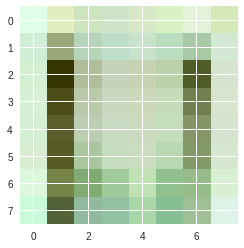

Epoch 199/2000... Discriminator Loss: 1.3912... Generator Loss: 0.4479
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Load

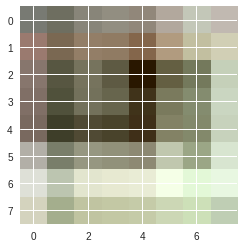

Epoch 299/2000... Discriminator Loss: 1.3777... Generator Loss: 0.4549
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

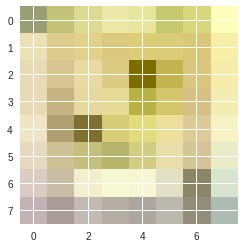

Epoch 399/2000... Discriminator Loss: 1.2827... Generator Loss: 0.4764
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Load

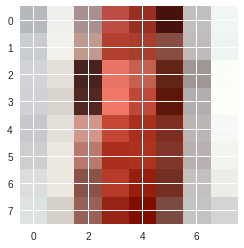

Epoch 499/2000... Discriminator Loss: 1.4159... Generator Loss: 0.4280
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

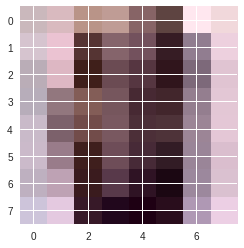

Epoch 599/2000... Discriminator Loss: 1.3989... Generator Loss: 0.4929
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Load

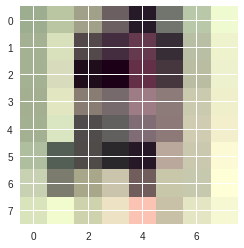

Epoch 699/2000... Discriminator Loss: 1.3915... Generator Loss: 0.5189
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

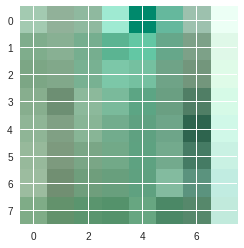

Epoch 799/2000... Discriminator Loss: 1.4368... Generator Loss: 0.4365
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Load

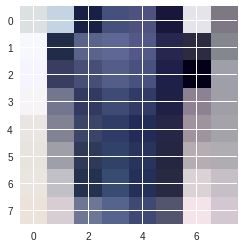

Epoch 899/2000... Discriminator Loss: 1.4481... Generator Loss: 0.4693
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

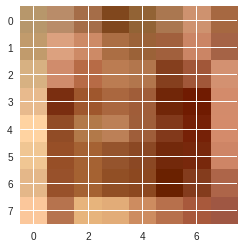

Epoch 999/2000... Discriminator Loss: 1.2425... Generator Loss: 0.4934
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Load

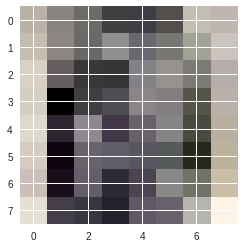

Epoch 1099/2000... Discriminator Loss: 1.2922... Generator Loss: 0.4936
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

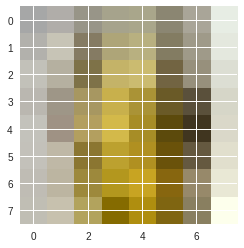

Epoch 1199/2000... Discriminator Loss: 1.5099... Generator Loss: 0.4579
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loa

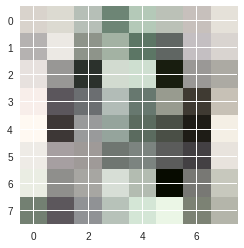

Epoch 1299/2000... Discriminator Loss: 1.2201... Generator Loss: 0.4790
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

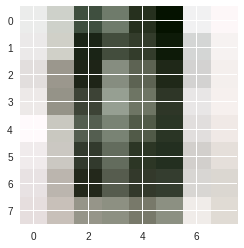

Epoch 1399/2000... Discriminator Loss: 1.3579... Generator Loss: 0.4848
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loa

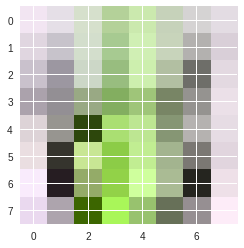

Epoch 1499/2000... Discriminator Loss: 1.2292... Generator Loss: 0.5101
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

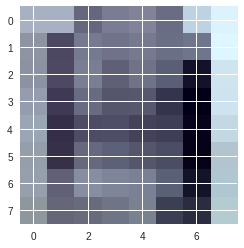

Epoch 1599/2000... Discriminator Loss: 1.2089... Generator Loss: 0.4804
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loa

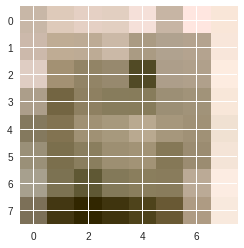

Epoch 1699/2000... Discriminator Loss: 1.1979... Generator Loss: 0.4877
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

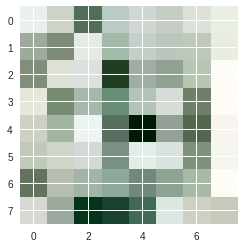

Epoch 1799/2000... Discriminator Loss: 1.2885... Generator Loss: 0.5060
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loa

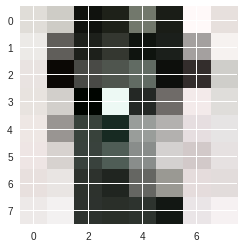

Epoch 1899/2000... Discriminator Loss: 1.2762... Generator Loss: 0.5037
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

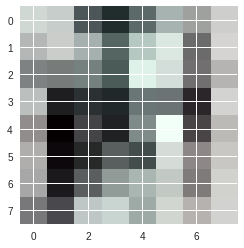

Epoch 1999/2000... Discriminator Loss: 1.3051... Generator Loss: 0.4879
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Eight
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loadi

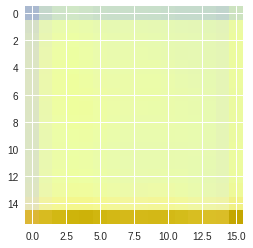

Epoch 99/3000... Discriminator Loss: 0.9793... Generator Loss: 0.4475
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


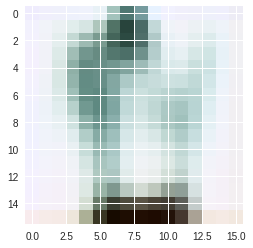

Epoch 199/3000... Discriminator Loss: 1.2028... Generator Loss: 0.4506
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Lo

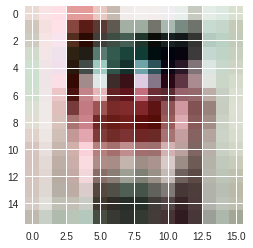

Epoch 299/3000... Discriminator Loss: 1.2810... Generator Loss: 0.4679
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

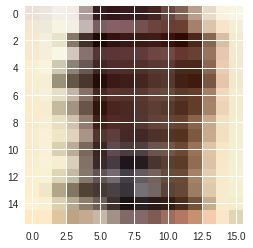

Epoch 399/3000... Discriminator Loss: 1.3295... Generator Loss: 0.4720
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Lo

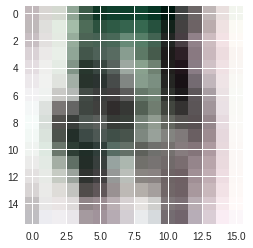

Epoch 499/3000... Discriminator Loss: 1.4282... Generator Loss: 0.4544
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

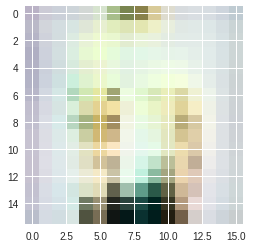

Epoch 599/3000... Discriminator Loss: 1.4083... Generator Loss: 0.5219
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Lo

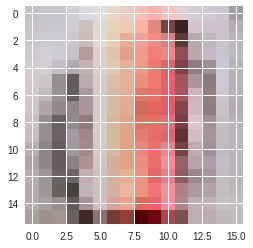

Epoch 699/3000... Discriminator Loss: 1.4403... Generator Loss: 0.4728
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

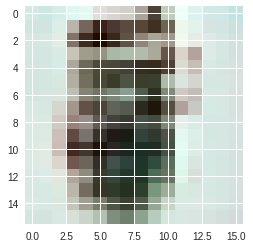

Epoch 799/3000... Discriminator Loss: 1.3930... Generator Loss: 0.4699
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Lo

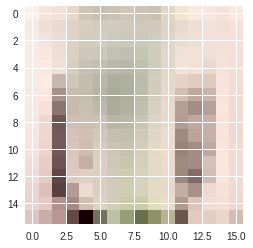

Epoch 899/3000... Discriminator Loss: 1.3537... Generator Loss: 0.4727
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

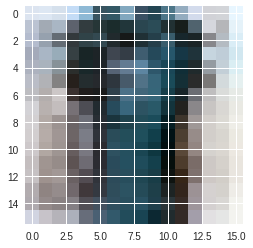

Epoch 999/3000... Discriminator Loss: 1.3529... Generator Loss: 0.4706
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Lo

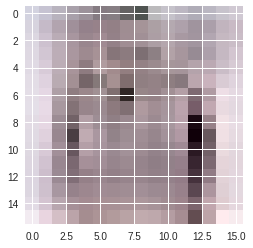

Epoch 1099/3000... Discriminator Loss: 1.4149... Generator Loss: 0.4933
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

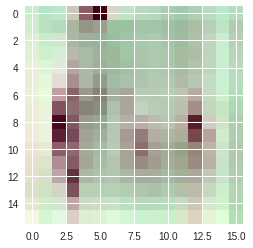

Epoch 1199/3000... Discriminator Loss: 1.3485... Generator Loss: 0.4683
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

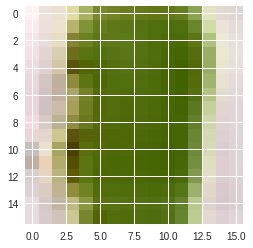

Epoch 1299/3000... Discriminator Loss: 1.3911... Generator Loss: 0.4506
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

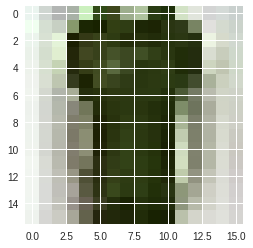

Epoch 1399/3000... Discriminator Loss: 1.2392... Generator Loss: 0.4863
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

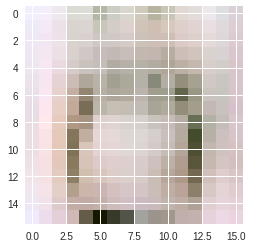

Epoch 1499/3000... Discriminator Loss: 1.3470... Generator Loss: 0.4830
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

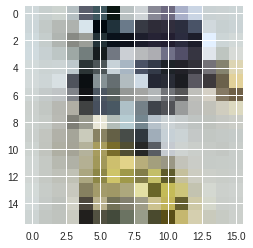

Epoch 1599/3000... Discriminator Loss: 1.3887... Generator Loss: 0.4509
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

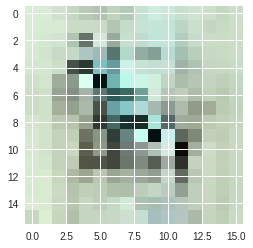

Epoch 1699/3000... Discriminator Loss: 1.5227... Generator Loss: 0.4079
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

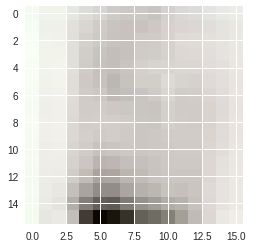

Epoch 1799/3000... Discriminator Loss: 1.3964... Generator Loss: 0.4996
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

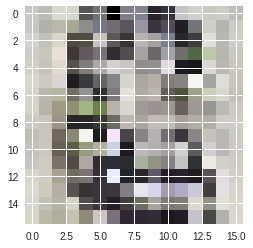

Epoch 1899/3000... Discriminator Loss: 1.2608... Generator Loss: 0.4674
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

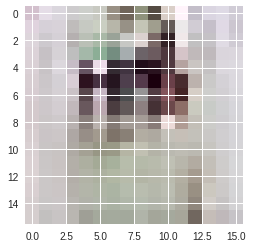

Epoch 1999/3000... Discriminator Loss: 1.2881... Generator Loss: 0.4817
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

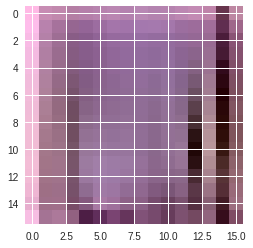

Epoch 2099/3000... Discriminator Loss: 1.3174... Generator Loss: 0.4734
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

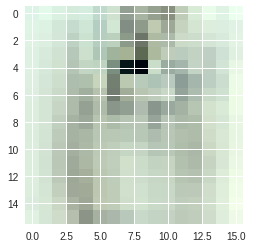

Epoch 2199/3000... Discriminator Loss: 1.4893... Generator Loss: 0.4148
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

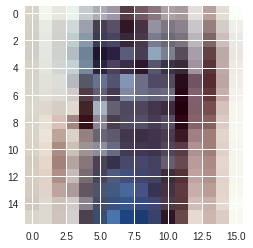

Epoch 2299/3000... Discriminator Loss: 1.3120... Generator Loss: 0.4708
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

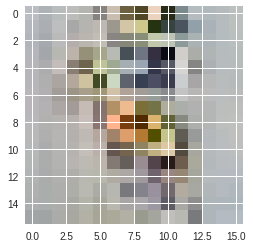

Epoch 2399/3000... Discriminator Loss: 1.2633... Generator Loss: 0.4726
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

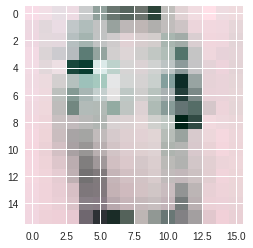

Epoch 2499/3000... Discriminator Loss: 1.2879... Generator Loss: 0.4951
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

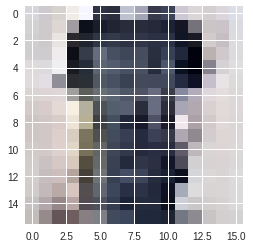

Epoch 2599/3000... Discriminator Loss: 1.2052... Generator Loss: 0.4879
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

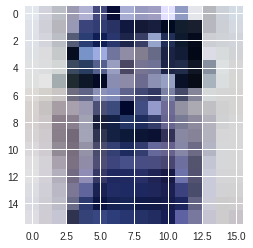

Epoch 2699/3000... Discriminator Loss: 1.2699... Generator Loss: 0.4843
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

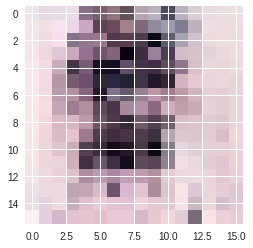

Epoch 2799/3000... Discriminator Loss: 1.1483... Generator Loss: 0.4943
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

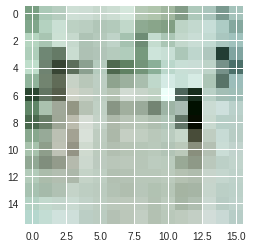

Epoch 2899/3000... Discriminator Loss: 1.2521... Generator Loss: 0.5509
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

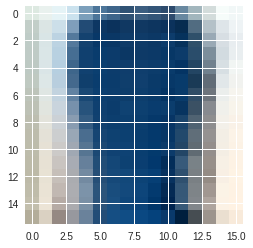

Epoch 2999/3000... Discriminator Loss: 1.3922... Generator Loss: 0.4186
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Sixteen
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loa

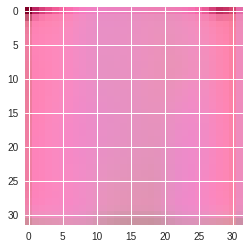

Epoch 99/4000... Discriminator Loss: 0.8662... Generator Loss: 0.4651
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


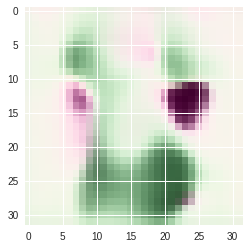

Epoch 199/4000... Discriminator Loss: 1.1147... Generator Loss: 0.4533
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


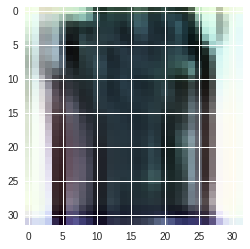

Epoch 299/4000... Discriminator Loss: 1.3046... Generator Loss: 0.4558
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

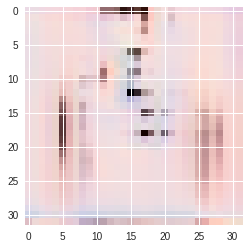

Epoch 399/4000... Discriminator Loss: 1.3943... Generator Loss: 0.4881
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


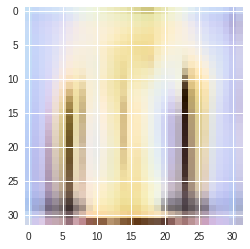

Epoch 499/4000... Discriminator Loss: 1.3954... Generator Loss: 0.5006
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

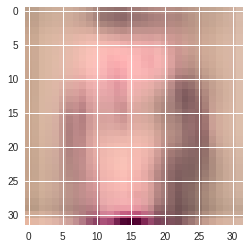

Epoch 599/4000... Discriminator Loss: 1.2664... Generator Loss: 0.4827
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


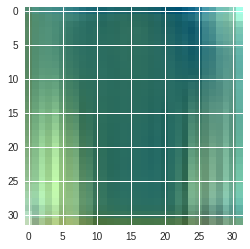

Epoch 699/4000... Discriminator Loss: 1.3461... Generator Loss: 0.4834
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

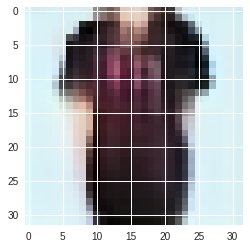

Epoch 799/4000... Discriminator Loss: 1.3221... Generator Loss: 0.4805
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


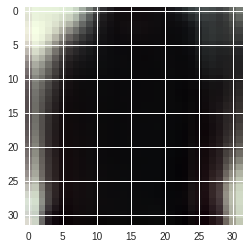

Epoch 899/4000... Discriminator Loss: 1.4316... Generator Loss: 0.4729
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

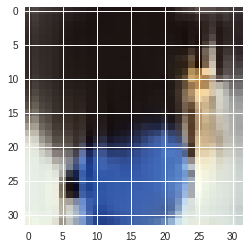

Epoch 999/4000... Discriminator Loss: 1.2533... Generator Loss: 0.4877
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


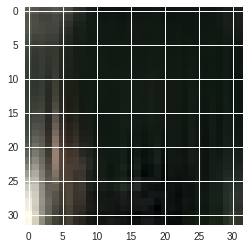

Epoch 1099/4000... Discriminator Loss: 1.2613... Generator Loss: 0.4635
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

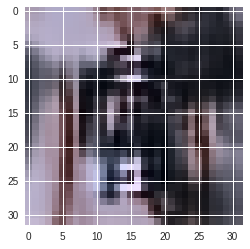

Epoch 1199/4000... Discriminator Loss: 1.3029... Generator Loss: 0.4817
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

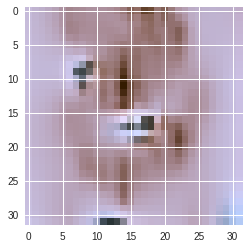

Epoch 1299/4000... Discriminator Loss: 1.2135... Generator Loss: 0.4822
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

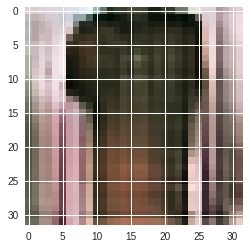

Epoch 1399/4000... Discriminator Loss: 1.3247... Generator Loss: 0.4447
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

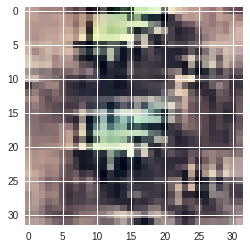

Epoch 1499/4000... Discriminator Loss: 1.3544... Generator Loss: 0.5093
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

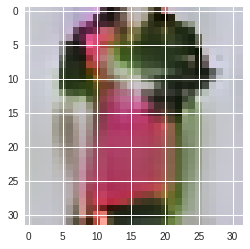

Epoch 1599/4000... Discriminator Loss: 1.0923... Generator Loss: 0.4995
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

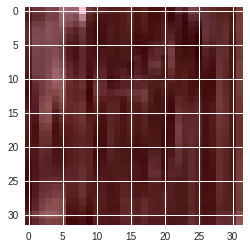

Epoch 1699/4000... Discriminator Loss: 2.1492... Generator Loss: 0.6384
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

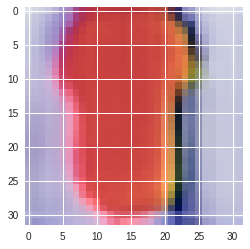

Epoch 1799/4000... Discriminator Loss: 1.3424... Generator Loss: 0.5342
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

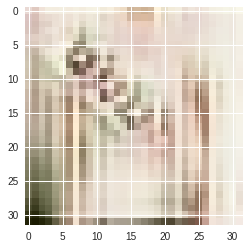

Epoch 1899/4000... Discriminator Loss: 0.7597... Generator Loss: 0.5308
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

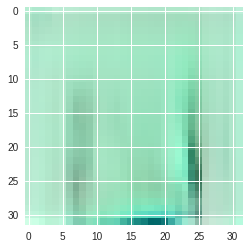

Epoch 1999/4000... Discriminator Loss: 1.2835... Generator Loss: 0.4717
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

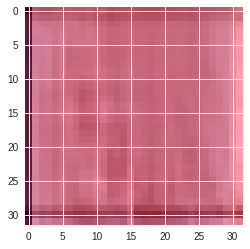

Epoch 2099/4000... Discriminator Loss: 1.2633... Generator Loss: 0.4818
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

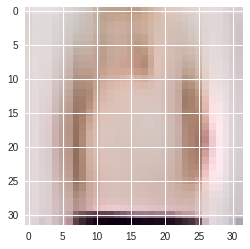

Epoch 2199/4000... Discriminator Loss: 1.1504... Generator Loss: 0.4675
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

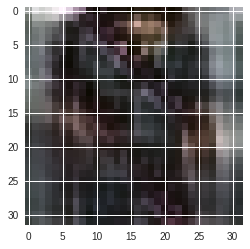

Epoch 2299/4000... Discriminator Loss: 0.9415... Generator Loss: 0.4933
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

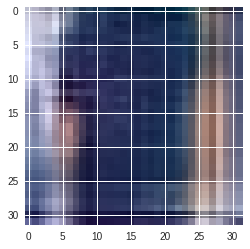

Epoch 2399/4000... Discriminator Loss: 0.7593... Generator Loss: 0.5436
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

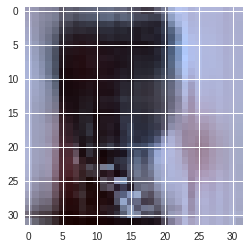

Epoch 2499/4000... Discriminator Loss: 1.6523... Generator Loss: 0.3989
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

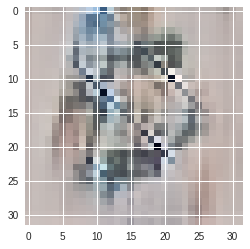

Epoch 2599/4000... Discriminator Loss: 1.7515... Generator Loss: 0.4119
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

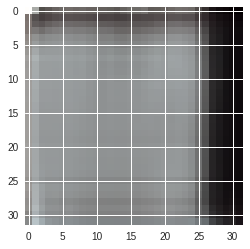

Epoch 2699/4000... Discriminator Loss: 0.7649... Generator Loss: 0.5557
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

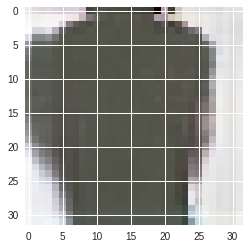

Epoch 2799/4000... Discriminator Loss: 0.8488... Generator Loss: 0.6264
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

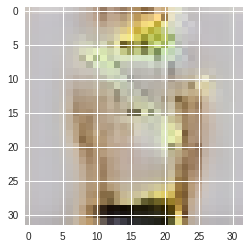

Epoch 2899/4000... Discriminator Loss: 1.0160... Generator Loss: 0.5440
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

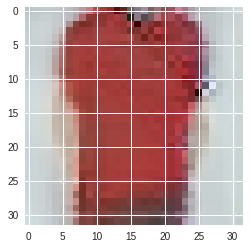

Epoch 2999/4000... Discriminator Loss: 1.0587... Generator Loss: 0.4997
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

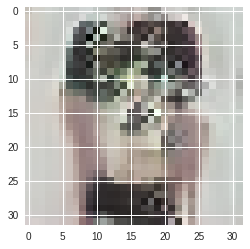

Epoch 3099/4000... Discriminator Loss: 1.2709... Generator Loss: 0.5130
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

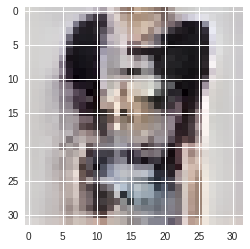

Epoch 3199/4000... Discriminator Loss: 0.8970... Generator Loss: 0.5330
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

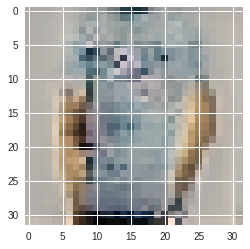

Epoch 3299/4000... Discriminator Loss: 1.0515... Generator Loss: 0.4787
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

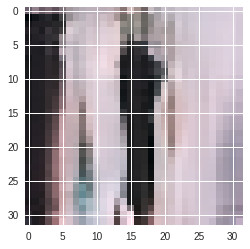

Epoch 3399/4000... Discriminator Loss: 1.4142... Generator Loss: 0.4385
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

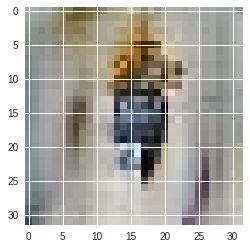

Epoch 3499/4000... Discriminator Loss: 0.8458... Generator Loss: 0.5145
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

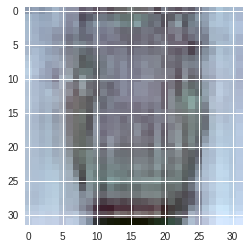

Epoch 3599/4000... Discriminator Loss: 0.5317... Generator Loss: 0.5663
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

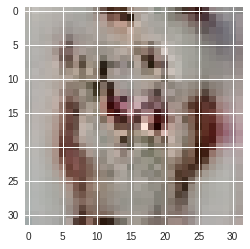

Epoch 3699/4000... Discriminator Loss: 0.8248... Generator Loss: 0.5860
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

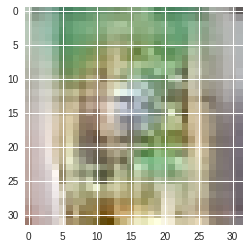

Epoch 3799/4000... Discriminator Loss: 0.6066... Generator Loss: 0.5693
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

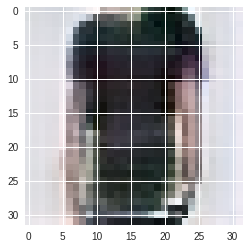

Epoch 3899/4000... Discriminator Loss: 0.8053... Generator Loss: 0.5422
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

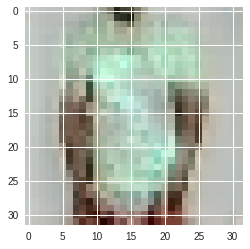

Epoch 3999/4000... Discriminator Loss: 0.7006... Generator Loss: 0.5572
saving Model
/content/drive/My Drive/Colab Notebooks/GAN/Models/Thirtytwo
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

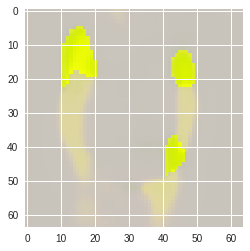

Epoch 99/5000... Discriminator Loss: 0.6104... Generator Loss: 0.5938
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


In [0]:
initialization=tf.truncated_normal_initializer(stddev=0.02)
#path=['Four','Eight','Sixteen','Thirtytwo','Sixtyfour','Onetwoeight']
path=['Four','Eight','Sixteen','Thirtytwo','Sixtyfour','Onetwoeight']
batch_size = [64,64,32,32,16,16]
#batch_size = [2,2,2,2,2,2]
z_dim =100
beta1=0.5
filters_list = [512,512,512,512,256,128]
#filters = {8:1024,16:512,32:256,64:128,128:64}
alpha= 0.2
learning_rate_D =  .00005 
#learning_rate_G= .00005
learning_rate_G = 0.0625
channels = 3
is_reuse = False  


from_checkpoint= False
resolution_list =[4,8,16,32,64,128]
epoch_list = [1000,2000,3000,4000,5000,6000]
#epoch_list = [5000,7000,9000,4000,5000,6000]

tf.reset_default_graph()
with tf.Session() as sess:
  

    
  sheets=0
  for i, res in enumerate(resolution_list):

      epochs= epoch_list[i]
      gan = GAN(sess,(res,res,3),z_dim,res,sheets,resolution_list)
      gan.train_on_batch(batch_size[i],path[i],epochs,beta1,alpha,learning_rate_G,learning_rate_D)
      is_reuse = tf.AUTO_REUSE 
      from_checkpoint=False
      sheets+=1
      
      print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")

In [0]:
class GAN(object):


  def __init__(self,sess,input_dim,z_dim,
               res,sheets,resolution_list):

    self.sess = sess
    self.input_dim = input_dim
    self.z_dim = z_dim
    self.epoch = tf.Variable(0)
    self.epochs = tf.Variable(0)
    self.res = res
    self.sheets= sheets

  def model_inputs(self,real_dim, z_dim):

    input_real = tf.placeholder(tf.float32,(None,*real_dim),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    lr_g = tf.placeholder(tf.float32,name='lr_g')
    lr_d = tf.placeholder(tf.float32,name='lr_d')

    return input_real,input_z,lr_g,lr_d
  
  
  
  def generator(self,z,is_reuse):
    with tf.variable_scope("generator",reuse =  is_reuse):
      previous_layer = None
      
      
      z = tf.layers.dense(z,4*4*512)
      layer = tf.reshape(z,(-1,4,4,512))
      layer= tf.nn.leaky_relu(layer,alpha=alpha)
      s= layer.get_shape().as_list()
      f=s[2]
      layer = new_sheet(filters[f], (4,4), 'same', 'genr_head_0_'+"{}".format(f))(layer)
      layer = new_sheet(filters[f], (3,3), 'same', 'genr_head_1_'+"{}".format(f))(layer)




      for i in range(self.sheets):

        layer = upscale2d(layer)   
        if i == self.sheets-1:
          previous_step = layer
          
          
        s= layer.get_shape().as_list()
        f=s[2]
        
        
        layer = new_sheet(filters[f], (4,4), 'same', 'genr_layer_0'+"{}".format(i))(layer)
        layer = new_sheet(filters[f], (3,3), 'same', 'genr_layer_1'+"{}".format(i))(layer)

      next_step = tf.layers.conv2d(layer,channels,(1,1),name="to_rgb_"+"{}".format(sheets)
                                   ,kernel_initializer = initialization)
      
     
      if previous_step is not None:
        
        previous_step = tf.layers.conv2d(layer,channels,(1,1),name="to_rgb_"+"{}".format(sheets-1)
                                   ,kernel_initializer = initialization)
        layer = previous_step +(next_step -previous_step)
      
      
        if self.res==64 or 32 or 16:  
          layer = attention(layer, channels , scope="attention"+"{}".format(i), reuse=is_reuse)
      
      else:
        
        layer = next_step 
        
        
      return layer 

    
    
    
    

  def discriminator(self,x, is_reuse):

    with tf.variable_scope("discriminator", reuse =  is_reuse):

      previous_layer= None
      input_layer = x
      
      
      s= x.get_shape().as_list()
      f=s[2]

      layer = tf.layers.conv2d(input_layer, filters[f],
                               (1,1), name = 'from_rgb'+"{}".format(self.res), 
                               kernel_initializer = initialization) 
      layer = tf.nn.leaky_relu(layer, alpha=0.2)

      
      for i in range(self.sheets, 0, -1):
        
        
        layer = new_sheet(filters_list[i], (3,3), 'same', 'disc_layer_b'+str(i), pix_norm = False)(layer)
        layer = new_sheet(filters_list[i - 1], (3,3), 'same', 'disc_layer_a'+str(i), pix_norm = False)(layer)
        layer = tf.layers.average_pooling2d(layer, 2, 2)
        
        
        
        
        
        
        
        

        layer = tf.layers.average_pooling2d(layer, 2, 2)
        if i == self.sheets:
          previous_layer = layer
        s= layer.get_shape().as_list()
        f=s[2]  
        layer = new_sheet(filters[f], (4,4), 'same', 'disc_layer_0'+"{}".format(i))(layer)
        layer = new_sheet(filters[f], (3,3), 'same', 'disc_layer_1'+"{}".format(i))(layer)


        if previous_layer is not None:
          previous_layer =new_sheet(filters[f], (1,1), 'same', 'disc_layer_prev'+"{}".format(i))(layer)
          layer = previous_layer+(layer-previous_layer)
          layer = new_sheet(filters[f], (1,1), 'same', 'disc_layer_concat'+"{}".format(i))(layer)
          
        if self.res==8 or 32 or 16:  
          layer = attention(layer,filters[f], scope="attention"+"{}".format(i), reuse=is_reuse)  


      layer = MiniBatchStddev(layer, group_size=4)
      s= layer.get_shape().as_list()
      f=s[2] 
      layer = new_sheet(filters[f], (3,3), 'same', 'disc_head_0'+"{}".format(self.res), pix_norm = False)(layer)
      layer = new_sheet(filters[f], (4,4), 'same', 'disc_head_1'+"{}".format(self.res), pix_norm = False)(layer)
      layer = tf.layers.flatten(layer)
      logits = tf.layers.dense(layer, 1, kernel_initializer = initialization)
      out= tf.sigmoid(logits)

      return out,logits

      
      


  def model_loss(self,input_real,input_z):
      g_model= self.generator(input_z,is_reuse)

      d_model_real,d_logits_real = self.discriminator(input_real,is_reuse)
      d_model_fake,d_logits_fake = self.discriminator(g_model,is_reuse= True)
      d_loss_real =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_real, labels = tf.ones_like(d_model_real)))
      d_loss_fake =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels = tf.zeros_like(d_model_fake)))
      g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_model_fake ,labels = tf.ones_like(d_model_fake)))
      d_loss = d_loss_real + d_loss_fake
      return d_loss , g_loss


  def model_optimizers(self,d_loss,g_loss ,lr_g,lr_d,beta1):
        t_vars = tf.trainable_variables()
        g_vars = [var for var in t_vars if var.name.startswith("generator")]
        d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        gen_updates = [op for op in update_ops if op.name.startswith("generator")]
        with tf.control_dependencies(gen_updates):
            with tf.variable_scope("discriminator", reuse = tf.AUTO_REUSE):
                d_train_opt = tf.train.AdamOptimizer(learning_rate =lr_d,beta1= beta1).minimize(d_loss, var_list= d_vars)
            with tf.variable_scope("generator", reuse = tf.AUTO_REUSE):
                g_train_opt = tf.train.AdamOptimizer(learning_rate =lr_g, beta1=beta1).minimize(g_loss, var_list= g_vars)
        return d_train_opt, g_train_opt  
  
            
            
            
            
            
  def train_on_batch(self,batch_size,path,epochs,beta1,alpha,
        learning_rate_G,learning_rate_D):
    
      input_images, input_z,lr_G, lr_D =self.model_inputs(self.input_dim, self.z_dim)
      d_loss, g_loss= self.model_loss(input_images, input_z)
      d_opt, g_opt = self.model_optimizers(d_loss, g_loss, lr_G, lr_D, beta1)
      
      saver = tf.train.Saver()
      if from_checkpoint:
          print("restoring model")
          saver.restore(sess,os.path.join(MODEL_DIR,"model.ckpt"))
      initialize_unit_vars(sess)
      writer = tf.summary.FileWriter(LOGS_DIR,sess.graph)
      self.epoch.load(0,self.sess)
      self.epochs.load(epochs,self.sess)
      i =0
      for epoch in range(epochs):
          self.epoch.load(epoch,self.sess)
          print("Loading images")
          batch_images= random_batch_generator(batch_size,path)
          batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
          
          
          learning_rate_D2= transition_alpha(learning_rate_D,epoch,epochs)
          learning_rate_G2= transition_alpha(learning_rate_G,epoch,epochs)
      
          _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D2})
          _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G2})

          i+=1
          if i % 50 == 0:
              train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
              train_loss_g = g_loss.eval({input_z: batch_z})
              example_z = np.random.uniform(-1, 1, size=[1, self.z_dim])
              samples = sess.run(self.generator(input_z,True),feed_dict={input_z: example_z})
              is_save= False
              
              
          if i % 100 == 0:
              is_save= True
              show_generator_output(samples,str(self.epoch),is_save)
              print("Epoch {}/{}...".format(epoch, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))

          if  i % 200 ==0:
              print("saving Model")
              save_path = saver.save(sess,os.path.join(MODEL_DIR,'model.ckpt'))  
  

Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading im

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


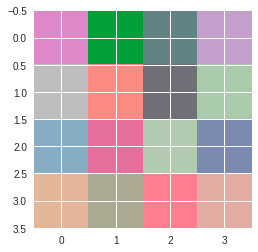

Epoch 99/5000... Discriminator Loss: 1.3270... Generator Loss: 0.4035
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


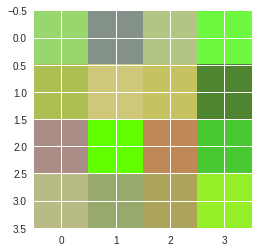

Epoch 199/5000... Discriminator Loss: 1.0777... Generator Loss: 0.4567
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

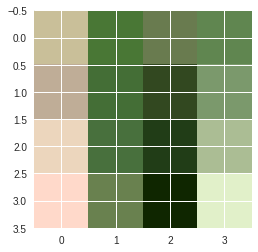

Epoch 299/5000... Discriminator Loss: 1.2379... Generator Loss: 0.4476
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

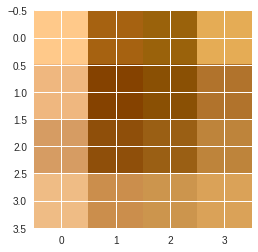

Epoch 399/5000... Discriminator Loss: 1.9066... Generator Loss: 0.3688
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

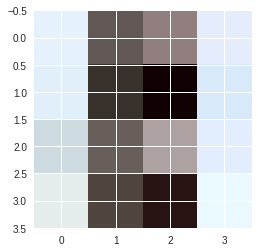

Epoch 499/5000... Discriminator Loss: 1.4586... Generator Loss: 0.4712
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

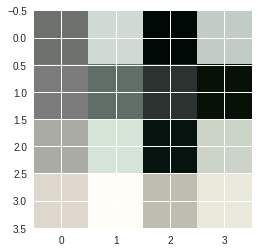

Epoch 599/5000... Discriminator Loss: 1.7390... Generator Loss: 0.3761
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

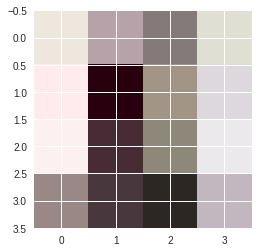

Epoch 699/5000... Discriminator Loss: 1.7779... Generator Loss: 0.3782
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

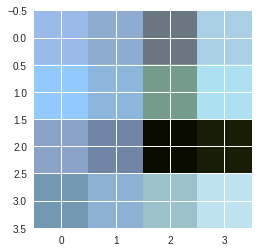

Epoch 799/5000... Discriminator Loss: 1.4767... Generator Loss: 0.4278
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

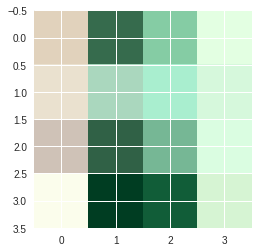

Epoch 899/5000... Discriminator Loss: 1.8102... Generator Loss: 0.3756
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

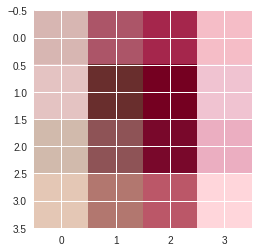

Epoch 999/5000... Discriminator Loss: 1.5633... Generator Loss: 0.5118
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

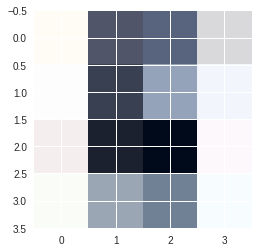

Epoch 1099/5000... Discriminator Loss: 1.3947... Generator Loss: 0.5075
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

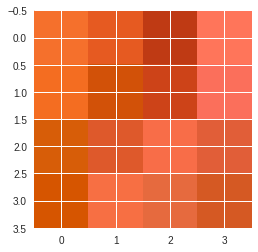

Epoch 1199/5000... Discriminator Loss: 1.5697... Generator Loss: 0.5103
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


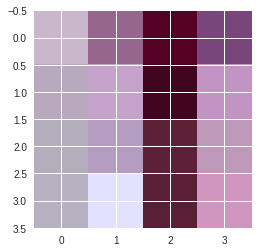

Epoch 1299/5000... Discriminator Loss: 1.5806... Generator Loss: 0.4256
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

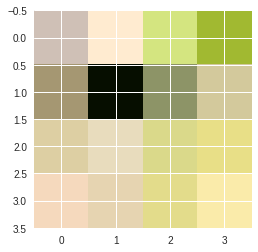

Epoch 1399/5000... Discriminator Loss: 1.3845... Generator Loss: 0.5269
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


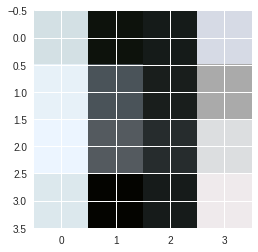

Epoch 1499/5000... Discriminator Loss: 1.5204... Generator Loss: 0.4913
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

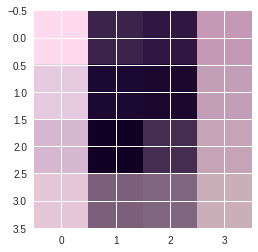

Epoch 1599/5000... Discriminator Loss: 1.5098... Generator Loss: 0.4588
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


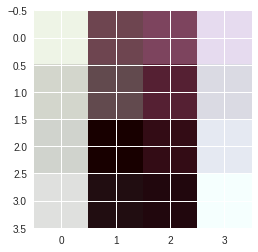

Epoch 1699/5000... Discriminator Loss: 1.3578... Generator Loss: 0.5094
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

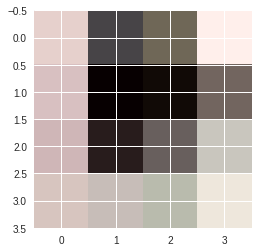

Epoch 1799/5000... Discriminator Loss: 1.3096... Generator Loss: 0.4434
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


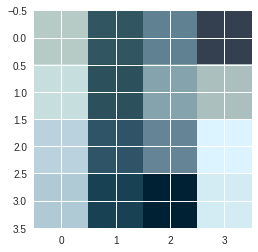

Epoch 1899/5000... Discriminator Loss: 1.4228... Generator Loss: 0.4755
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

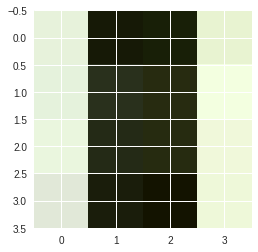

Epoch 1999/5000... Discriminator Loss: 1.2472... Generator Loss: 0.5344
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


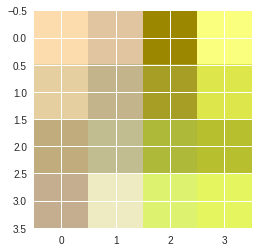

Epoch 2099/5000... Discriminator Loss: 1.3399... Generator Loss: 0.4811
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

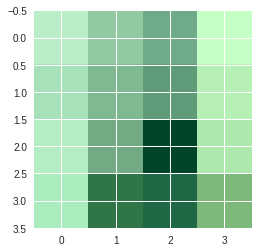

Epoch 2199/5000... Discriminator Loss: 1.4831... Generator Loss: 0.5080
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


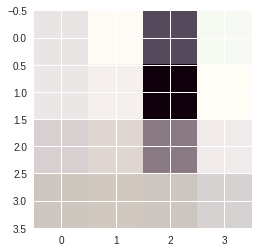

Epoch 2299/5000... Discriminator Loss: 1.3705... Generator Loss: 0.4832
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

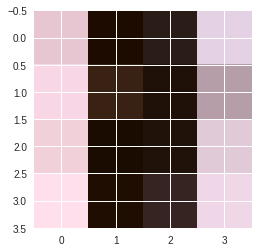

Epoch 2399/5000... Discriminator Loss: 1.3048... Generator Loss: 0.4463
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


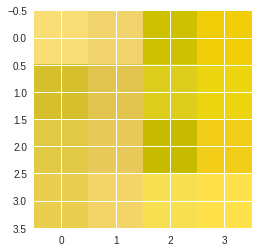

Epoch 2499/5000... Discriminator Loss: 1.3002... Generator Loss: 0.4643
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

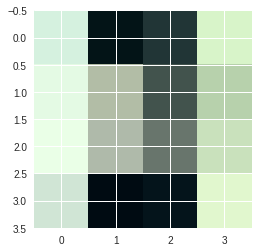

Epoch 2599/5000... Discriminator Loss: 1.2896... Generator Loss: 0.5029
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


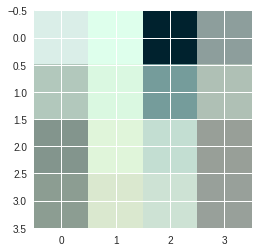

Epoch 2699/5000... Discriminator Loss: 1.3354... Generator Loss: 0.4941
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

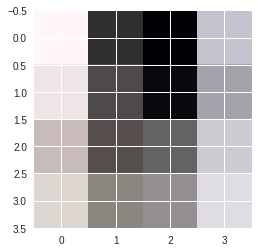

Epoch 2799/5000... Discriminator Loss: 1.3402... Generator Loss: 0.5235
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


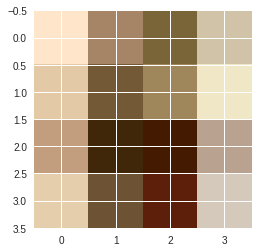

Epoch 2899/5000... Discriminator Loss: 1.3530... Generator Loss: 0.4753
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

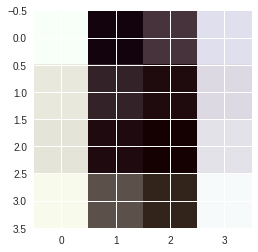

Epoch 2999/5000... Discriminator Loss: 1.3885... Generator Loss: 0.4863
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


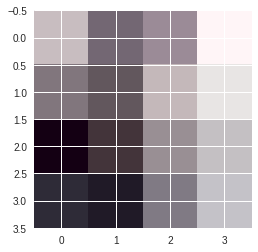

Epoch 3099/5000... Discriminator Loss: 1.4072... Generator Loss: 0.4598
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

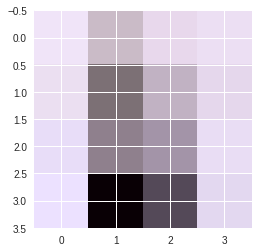

Epoch 3199/5000... Discriminator Loss: 1.3371... Generator Loss: 0.4512
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


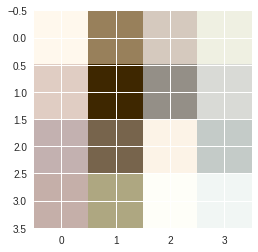

Epoch 3299/5000... Discriminator Loss: 1.4838... Generator Loss: 0.4485
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

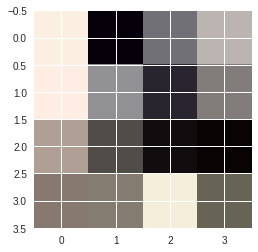

Epoch 3399/5000... Discriminator Loss: 1.2863... Generator Loss: 0.4953
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


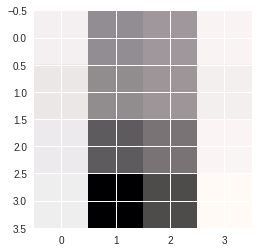

Epoch 3499/5000... Discriminator Loss: 1.3327... Generator Loss: 0.4812
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

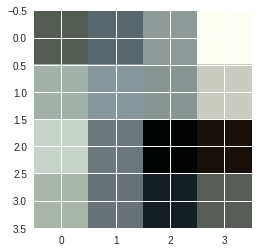

Epoch 3599/5000... Discriminator Loss: 1.3548... Generator Loss: 0.4909
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


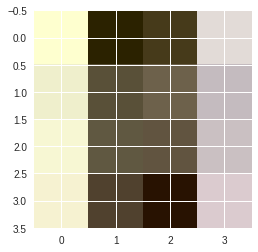

Epoch 3699/5000... Discriminator Loss: 1.3707... Generator Loss: 0.4722
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

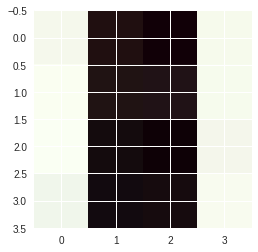

Epoch 3799/5000... Discriminator Loss: 1.2827... Generator Loss: 0.4833
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


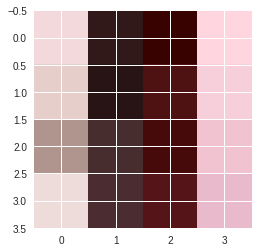

Epoch 3899/5000... Discriminator Loss: 1.2646... Generator Loss: 0.4811
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

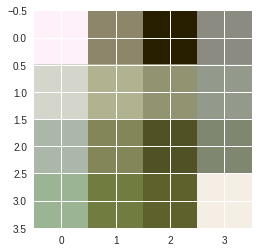

Epoch 3999/5000... Discriminator Loss: 1.3501... Generator Loss: 0.4749
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


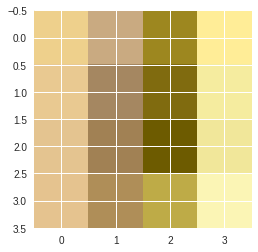

Epoch 4099/5000... Discriminator Loss: 1.3972... Generator Loss: 0.4631
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

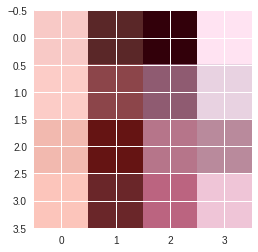

Epoch 4199/5000... Discriminator Loss: 1.3558... Generator Loss: 0.4618
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


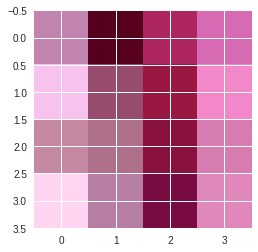

Epoch 4299/5000... Discriminator Loss: 1.3666... Generator Loss: 0.4523
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

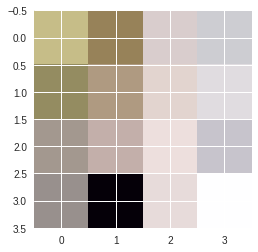

Epoch 4399/5000... Discriminator Loss: 1.3673... Generator Loss: 0.4920
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


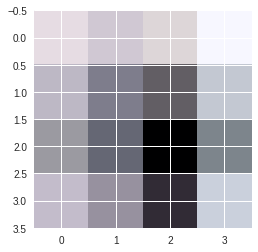

Epoch 4499/5000... Discriminator Loss: 1.4232... Generator Loss: 0.4906
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

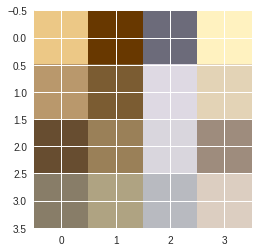

Epoch 4599/5000... Discriminator Loss: 1.3678... Generator Loss: 0.4873
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


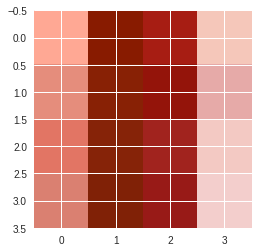

Epoch 4699/5000... Discriminator Loss: 1.3356... Generator Loss: 0.4728
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

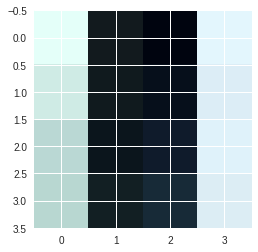

Epoch 4799/5000... Discriminator Loss: 1.4180... Generator Loss: 0.4791
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


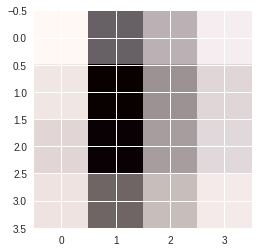

Epoch 4899/5000... Discriminator Loss: 1.3305... Generator Loss: 0.4826
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

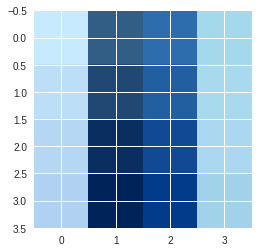

Epoch 4999/5000... Discriminator Loss: 1.4066... Generator Loss: 0.4584
saving Model
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Lo

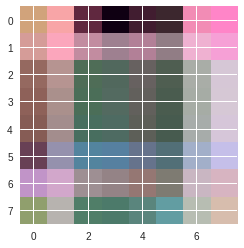

Epoch 99/7000... Discriminator Loss: 1.5824... Generator Loss: 0.4550
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


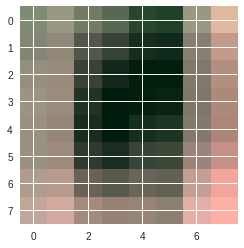

Epoch 199/7000... Discriminator Loss: 1.3984... Generator Loss: 0.4785
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

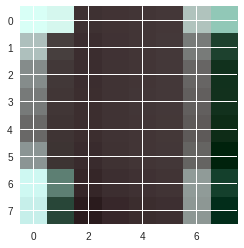

Epoch 299/7000... Discriminator Loss: 1.4081... Generator Loss: 0.4714
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

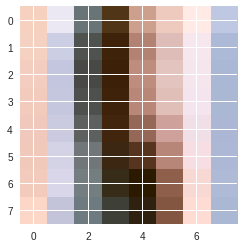

Epoch 399/7000... Discriminator Loss: 1.3187... Generator Loss: 0.4843
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

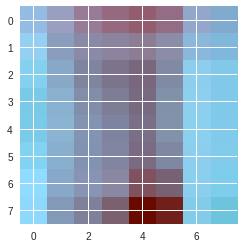

Epoch 499/7000... Discriminator Loss: 1.3640... Generator Loss: 0.4448
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

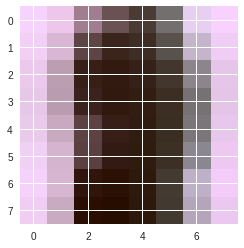

Epoch 599/7000... Discriminator Loss: 1.3256... Generator Loss: 0.4783
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

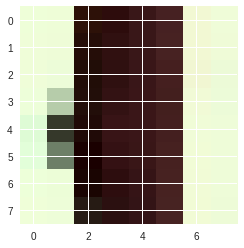

Epoch 699/7000... Discriminator Loss: 1.2235... Generator Loss: 0.4960
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

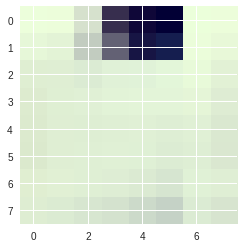

Epoch 799/7000... Discriminator Loss: 1.3417... Generator Loss: 0.4923
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

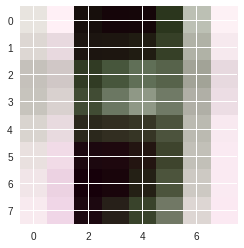

Epoch 899/7000... Discriminator Loss: 1.5147... Generator Loss: 0.5562
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images

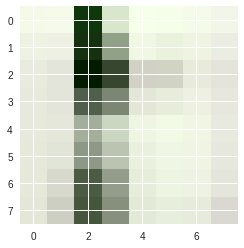

Epoch 999/7000... Discriminator Loss: 1.3844... Generator Loss: 0.4472
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
L

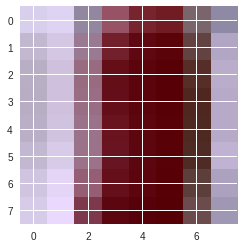

Epoch 1099/7000... Discriminator Loss: 1.2479... Generator Loss: 0.5030
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

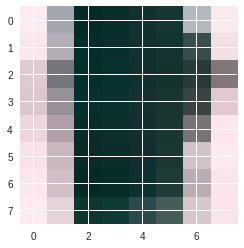

Epoch 1199/7000... Discriminator Loss: 1.3634... Generator Loss: 0.5089
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


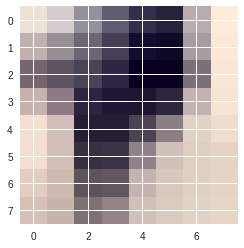

Epoch 1299/7000... Discriminator Loss: 1.3465... Generator Loss: 0.4631
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

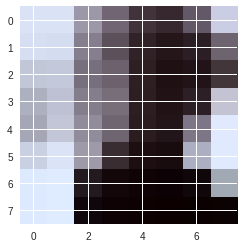

Epoch 1399/7000... Discriminator Loss: 1.1646... Generator Loss: 0.5212
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


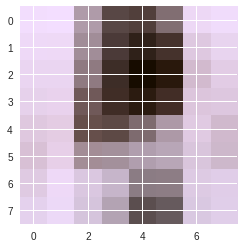

Epoch 1499/7000... Discriminator Loss: 1.4199... Generator Loss: 0.4699
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

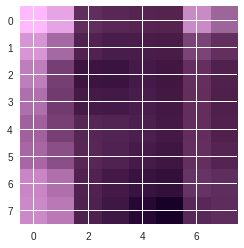

Epoch 1599/7000... Discriminator Loss: 1.3917... Generator Loss: 0.5005
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


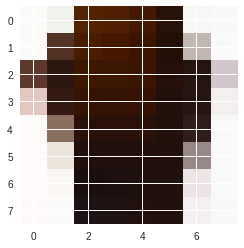

Epoch 1699/7000... Discriminator Loss: 1.3281... Generator Loss: 0.4821
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

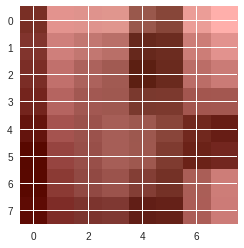

Epoch 1799/7000... Discriminator Loss: 1.4649... Generator Loss: 0.4217
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


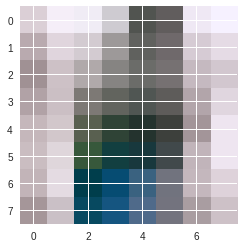

Epoch 1899/7000... Discriminator Loss: 1.3630... Generator Loss: 0.4752
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

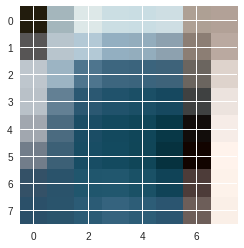

Epoch 1999/7000... Discriminator Loss: 1.2949... Generator Loss: 0.4758
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


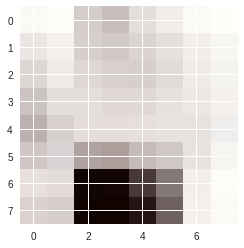

Epoch 2099/7000... Discriminator Loss: 1.3850... Generator Loss: 0.4481
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

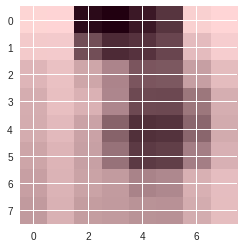

Epoch 2199/7000... Discriminator Loss: 1.3657... Generator Loss: 0.4884
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


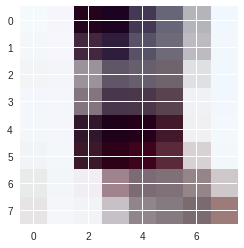

Epoch 2299/7000... Discriminator Loss: 1.3910... Generator Loss: 0.4726
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

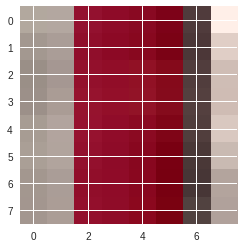

Epoch 2399/7000... Discriminator Loss: 1.3799... Generator Loss: 0.4678
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


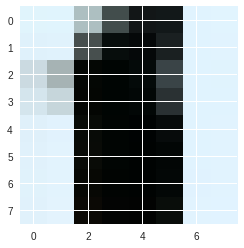

Epoch 2499/7000... Discriminator Loss: 1.4117... Generator Loss: 0.4716
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

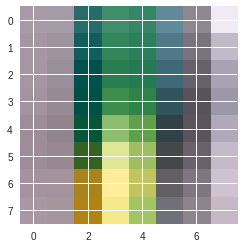

Epoch 2599/7000... Discriminator Loss: 1.3860... Generator Loss: 0.4899
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


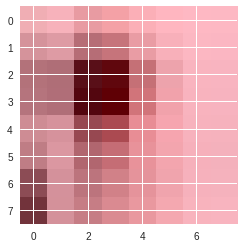

Epoch 2699/7000... Discriminator Loss: 1.3856... Generator Loss: 0.4700
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

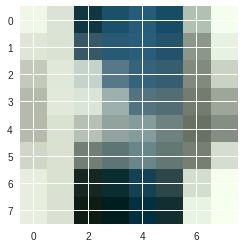

Epoch 2799/7000... Discriminator Loss: 1.4145... Generator Loss: 0.4600
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


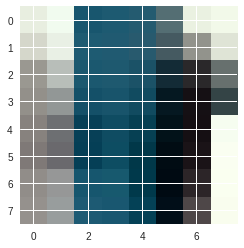

Epoch 2899/7000... Discriminator Loss: 1.3702... Generator Loss: 0.4747
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

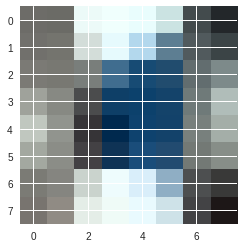

Epoch 2999/7000... Discriminator Loss: 1.3769... Generator Loss: 0.5011
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


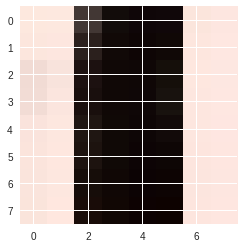

Epoch 3099/7000... Discriminator Loss: 1.3962... Generator Loss: 0.4859
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

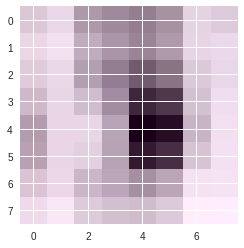

Epoch 3199/7000... Discriminator Loss: 1.3796... Generator Loss: 0.4755
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


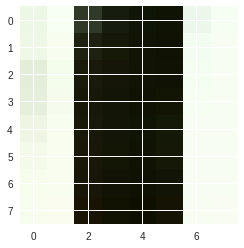

Epoch 3299/7000... Discriminator Loss: 1.3753... Generator Loss: 0.4809
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

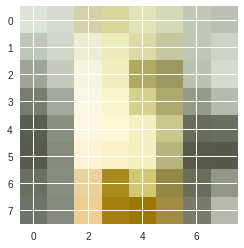

Epoch 3399/7000... Discriminator Loss: 1.4122... Generator Loss: 0.4693
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


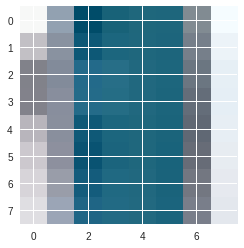

Epoch 3499/7000... Discriminator Loss: 1.4045... Generator Loss: 0.4747
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

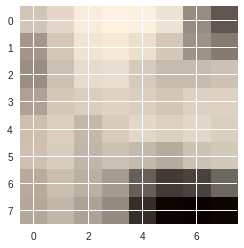

Epoch 3599/7000... Discriminator Loss: 1.4249... Generator Loss: 0.4647
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


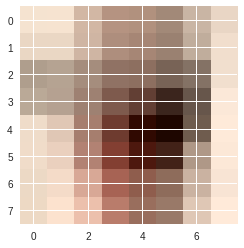

Epoch 3699/7000... Discriminator Loss: 1.3874... Generator Loss: 0.4817
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

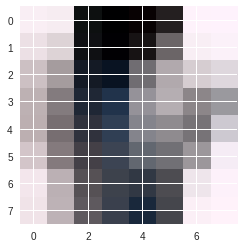

Epoch 3799/7000... Discriminator Loss: 1.3773... Generator Loss: 0.4765
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


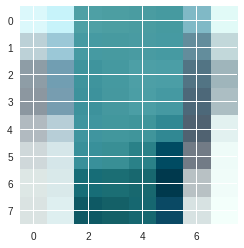

Epoch 3899/7000... Discriminator Loss: 1.3865... Generator Loss: 0.4751
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

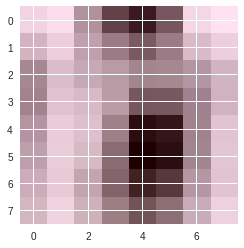

Epoch 3999/7000... Discriminator Loss: 1.3865... Generator Loss: 0.4786
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


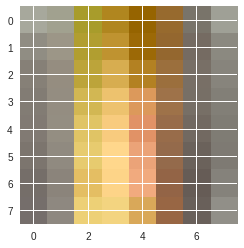

Epoch 4099/7000... Discriminator Loss: 1.3796... Generator Loss: 0.4758
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

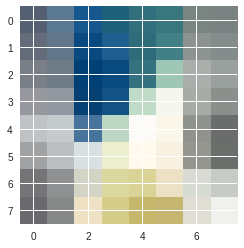

Epoch 4199/7000... Discriminator Loss: 1.4009... Generator Loss: 0.5085
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


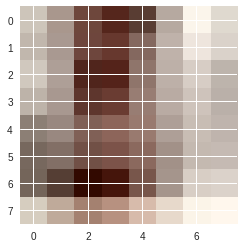

Epoch 4299/7000... Discriminator Loss: 1.3925... Generator Loss: 0.4739
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

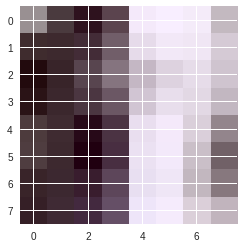

Epoch 4399/7000... Discriminator Loss: 1.3700... Generator Loss: 0.4756
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


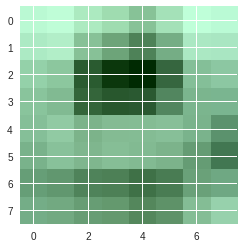

Epoch 4499/7000... Discriminator Loss: 1.3633... Generator Loss: 0.4842
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

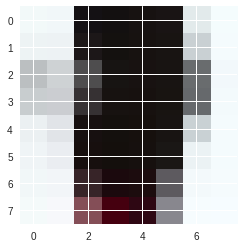

Epoch 4599/7000... Discriminator Loss: 1.3874... Generator Loss: 0.4598
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


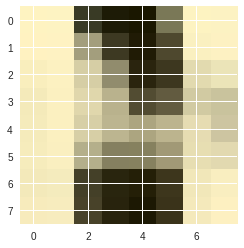

Epoch 4699/7000... Discriminator Loss: 1.3847... Generator Loss: 0.4801
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

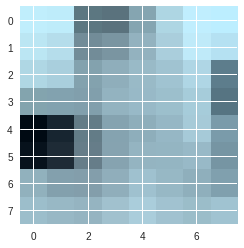

Epoch 4799/7000... Discriminator Loss: 1.4000... Generator Loss: 0.5072
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


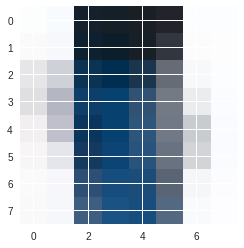

Epoch 4899/7000... Discriminator Loss: 1.3955... Generator Loss: 0.4720
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

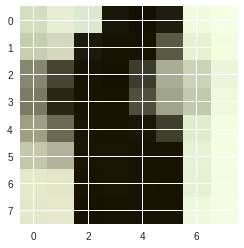

Epoch 4999/7000... Discriminator Loss: 1.3821... Generator Loss: 0.4765
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


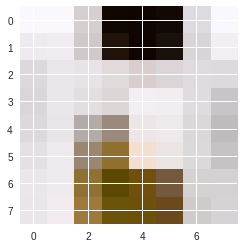

Epoch 5099/7000... Discriminator Loss: 1.3837... Generator Loss: 0.4781
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

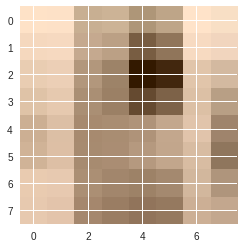

Epoch 5199/7000... Discriminator Loss: 1.3756... Generator Loss: 0.4788
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


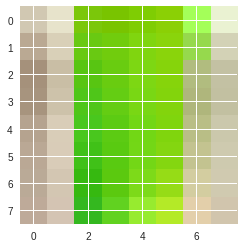

Epoch 5299/7000... Discriminator Loss: 1.3835... Generator Loss: 0.4701
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading image

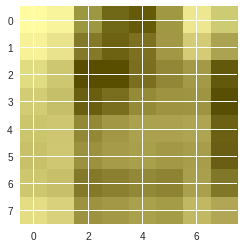

Epoch 5399/7000... Discriminator Loss: 1.3942... Generator Loss: 0.4698
saving Model
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images
Loading images


In [0]:
initialization=tf.truncated_normal_initializer(stddev=0.02)
#path=['Four','Eight','Sixteen','Thirtytwo','Sixtyfour','Onetwoeight']
path=['Four','Eight','Sixteen','Thirtytwo','Sixtyfour','Onetwoeight']
batch_size = [64,64,32,32,16,16]
#batch_size = [2,2,2,2,2,2]
z_dim =100
beta1=0.5
filters={4:512,8:256,16:128,32:64,64:32,128:16}
#filters = {8:1024,16:512,32:256,64:128,128:64}
alpha= 0.2
learning_rate_D =  .00005 
#learning_rate_G= .00005
learning_rate_G = 0.0625
channels = 3
is_reuse = False  


from_checkpoint= False
resolution_list =[4,8,16,32,64,128]
#epoch_list = [1,2,3,4,5,6]
epoch_list = [5000,7000,9000,4000,5000,6000]

tf.reset_default_graph()
with tf.Session() as sess:
  

    
  sheets=0
  for i, res in enumerate(resolution_list):

      epochs= epoch_list[i]
      gan = GAN(sess,(res,res,3),z_dim,res,sheets,resolution_list)
      gan.train_on_batch(batch_size[i],path[i],epochs,beta1,alpha,learning_rate_G,learning_rate_D)
      is_reuse = tf.AUTO_REUSE 
      from_checkpoint=False
      sheets+=1

      print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")